In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'mlp_lasso_penalty'
)

plot_gene = 'KRAS'
metric = 'aupr'

In [3]:
def load_prediction_results_sgd_pytorch(results_dir, gene):
    results_df = pd.DataFrame()
    for gene_name in os.listdir(results_dir):
        # if gene argument is provided, only process files for that gene
        if gene not in gene_name: continue
        gene_dir = os.path.join(results_dir, gene_name)
        if not os.path.isdir(gene_dir): continue
        for results_file in os.listdir(gene_dir):
            if not ('metrics' in results_file): continue
            if results_file[0] == '.': continue
            full_results_file = os.path.join(gene_dir, results_file)
            gene_results_df = pd.read_csv(full_results_file, sep='\t')
            lasso_param = results_file.split('_')[-3].replace('c', '')
            gene_results_df['lasso_param'] = lasso_param
            learning_rate = results_file.split('_')[-4].replace('lr', '')
            gene_results_df['learning_rate'] = learning_rate
            # if identifier_from_fname:
            #     identifier = results_file.split('_')[0]
            #     gene_results_df['identifier'] = identifier
            results_df = pd.concat((results_df, gene_results_df))
    return results_df

In [4]:
perf_df = (
    load_prediction_results_sgd_pytorch(results_dir, plot_gene)
      .drop(columns=['holdout_cancer_type'])
      .copy()
)

print(perf_df.shape)
print(perf_df.lasso_param.unique())
print(perf_df.learning_rate.unique())
perf_df.head()

(732, 9)
['5e-05' '0.001' '0.1' '0.5' '0.0005' '0.01' '0.0001' '1e-05' '0.05'
 '0.005' '1.0']
['0.1' '0.005' '0.05' '0.001' '0.0005' '0.01']


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param,learning_rate
0,1.00000,1.00000,KRAS,signal,42,train,0,5e-05,0.1
1,0.75474,0.46212,KRAS,signal,42,test,0,5e-05,0.1
2,0.75486,0.43135,KRAS,signal,42,cv,0,5e-05,0.1
3,0.99440,0.97270,KRAS,signal,42,train,1,5e-05,0.1
4,0.74750,0.45788,KRAS,signal,42,test,1,5e-05,0.1


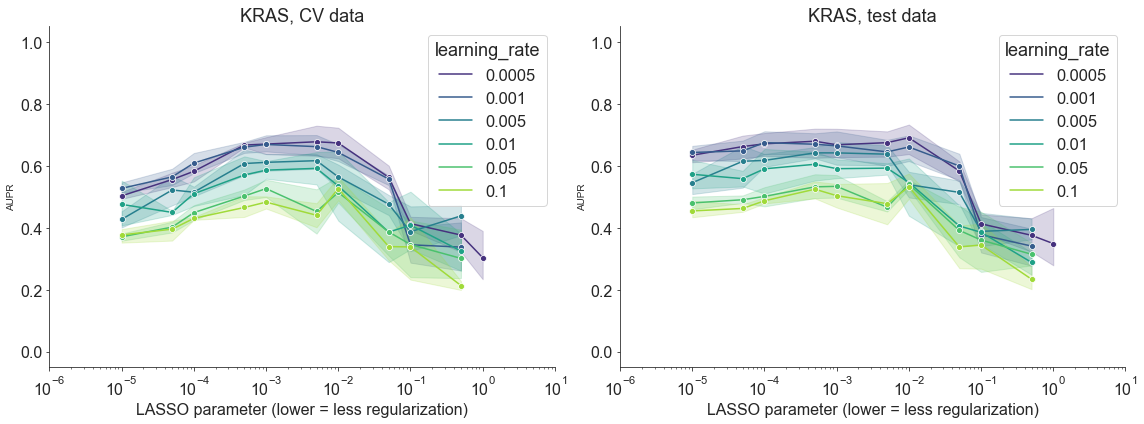

In [5]:
sns.set({'figure.figsize': (16, 6)})
sns.set_style('ticks')

fig, axarr = plt.subplots(1, 2)

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['learning_rate', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)
# plot_df.learning_rate = plot_df.learning_rate.astype(float)

with sns.plotting_context('notebook', font_scale=1.5):
    sns.lineplot(
        data=plot_df[plot_df.data_type == 'cv'],
        x='lasso_param', y=metric, hue='learning_rate', marker='o',
        palette='viridis', ax=axarr[0]
    )
    axarr[0].set(xscale='log', 
                 xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    axarr[0].set_xlabel('LASSO parameter (lower = less regularization)', size=16)
    axarr[0].set_xlim((10e-7, 10))
    axarr[0].set_ylim((-0.05, 1.05))
    axarr[0].set_ylabel(f'{metric.upper()}')
    axarr[0].set_title(f'{plot_gene}, CV data')
    axarr[0].tick_params(axis='both', labelsize=16)
    axarr[0].spines['right'].set_visible(False)
    axarr[0].spines['top'].set_visible(False)
    
    sns.lineplot(
        data=plot_df[plot_df.data_type == 'test'],
        x='lasso_param', y=metric, hue='learning_rate', marker='o',
        palette='viridis', ax=axarr[1]
    )
    axarr[1].set(xscale='log', 
                 xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    axarr[1].set_xlabel('LASSO parameter (lower = less regularization)', size=16)
    axarr[1].set_xlim((10e-7, 10))
    axarr[1].set_ylim((-0.05, 1.05))
    axarr[1].set_ylabel(f'{metric.upper()}')
    axarr[1].set_title(f'{plot_gene}, test data')
    axarr[1].tick_params(axis='both', labelsize=16)
    axarr[1].spines['right'].set_visible(False)
    axarr[1].spines['top'].set_visible(False)

plt.tight_layout()

In [6]:
learning_rate = '0.0005'

plot_df = (
    perf_df[(perf_df.signal == 'signal') &
            (perf_df.learning_rate == learning_rate)]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)
plot_df.learning_rate = plot_df.learning_rate.astype(float)

plot_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param,learning_rate
0,1.00000,1.00000,KRAS,signal,42,train,3,0.0001,0.0005
1,1.00000,1.00000,KRAS,signal,42,train,0,0.0001,0.0005
2,0.83278,0.61276,KRAS,signal,42,test,0,0.0001,0.0005
3,0.81763,0.60386,KRAS,signal,42,cv,0,0.0001,0.0005
4,1.00000,1.00000,KRAS,signal,42,train,1,0.0001,0.0005


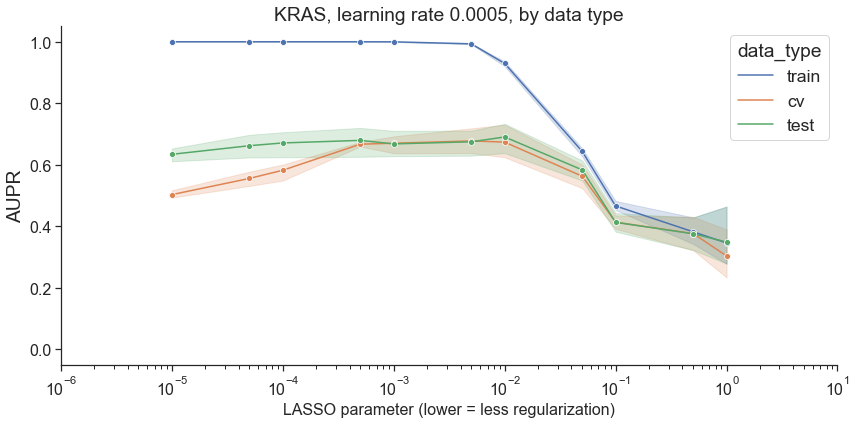

In [7]:
sns.set({'figure.figsize': (12, 6)})
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    sns.lineplot(
        data=plot_df, x='lasso_param', y=metric,
        marker='o', hue='data_type',
        hue_order=['train', 'cv', 'test']
    )
    ax = plt.gca()
    ax.set(xscale='log', 
           xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    ax.set_xlabel('LASSO parameter (lower = less regularization)', size=16)
    ax.set_xlim((10e-7, 10))
    ax.set_ylim((-0.05, 1.05))
    ax.set_ylabel(f'{metric.upper()}')
    ax.set_title(f'{plot_gene}, learning rate {learning_rate}, by data type')
    ax.tick_params(axis='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()